In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Read in an image
import numpy as np
from PIL import Image

# Youll need to put an image here. I've got a picture of apples
img = Image.open("../../assets/test_imgs/apples.png").convert("L")
img.load()
img = np.asarray(img)

In [3]:
# Resize the image to something better
from skimage.transform import resize
img = resize(img, (128, 128), anti_aliasing=True)

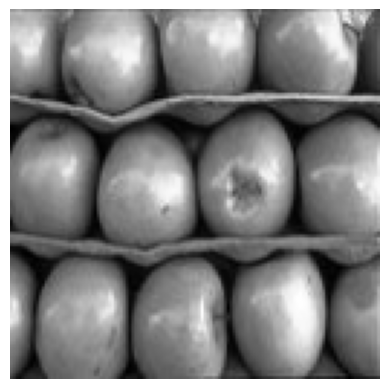

In [4]:
import matplotlib.pyplot as plt

plt.imshow(img, cmap="gray")
_ = plt.axis("off")

In [5]:
# We'll artificially create some patches by cropping the image into smaller pieces
from skimage.util import view_as_windows

patch_size = (32, 32)
assert all(p == patch_size[0] for p in patch_size), "Patch size must be square"

patches = view_as_windows(img, patch_size, step=patch_size[0])

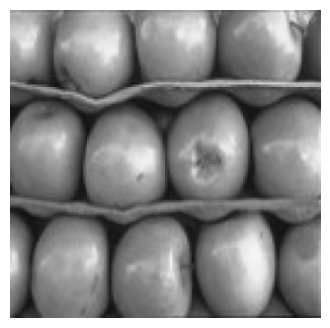

In [6]:
def plot_grid(patches: list[list[np.ndarray]]) -> plt.Figure:
    fig, axes = plt.subplots(
        len(patches),
        len(patches[0]),
        figsize=(len(patches), len(patches[0])),
        gridspec_kw={"wspace": 0.00, "hspace": 0.00},
    )
    for axes_row, patches_row in zip(axes, patches, strict=True):
        for axis, patch in zip(axes_row, patches_row, strict=True):
            axis.imshow(patch, cmap="gray", vmin=0, vmax=1, aspect="auto")
            axis.axis("off")

    return fig


_ = plot_grid(patches)

In [7]:
# Choose patches randomly
from current_denoising.generation import quilting

# I expect to pass a flat list of patches to my function
patches = patches.reshape(-1, 32, 32)

target_size = (128, 128)
patch_overlap = 4

rng = np.random.default_rng(0)

random_patch_grid = quilting.randomly_choose_patches(
    patches, target_size, patch_overlap, allow_rotation=False, rng=rng
)

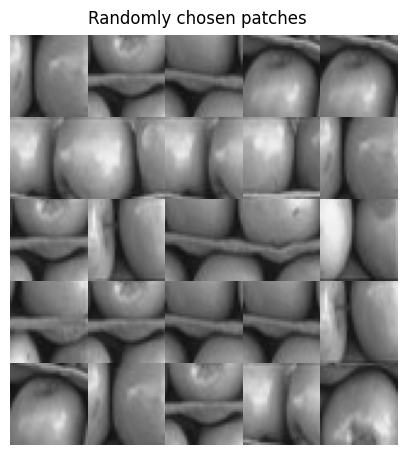

In [8]:
fig = plot_grid(random_patch_grid)
fig.suptitle("Randomly chosen patches")
fig.subplots_adjust(top=0.93)

In [9]:
rng = np.random.default_rng(0)

optimal_patch_grid = quilting.optimally_choose_patches(
    patches, target_size, patch_overlap, allow_rotation=False, rng=rng
)

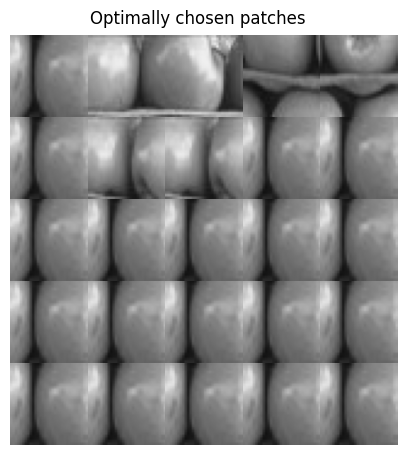

In [10]:
fig = plot_grid(optimal_patch_grid)
fig.suptitle("Optimally chosen patches")
fig.subplots_adjust(top=0.93)

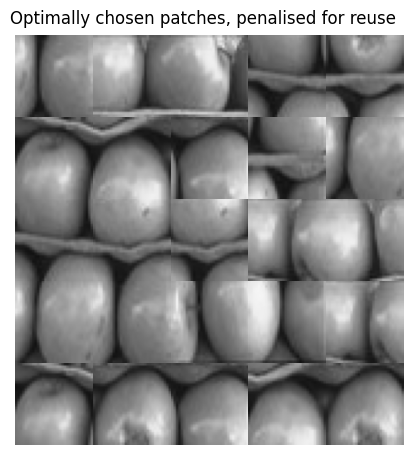

In [11]:
rng = np.random.default_rng(0)
penalised_patch_grid = quilting.optimally_choose_patches(
    patches,
    target_size,
    patch_overlap,
    allow_rotation=False,
    rng=rng,
    repeat_penalty=1,
)
fig = plot_grid(penalised_patch_grid)
fig.suptitle("Optimally chosen patches, penalised for reuse")
fig.subplots_adjust(top=0.93)

In [12]:
# We can join these naively,by just averaging the overlapping regions
naive_images = [img] + [
    quilting.naive_quilt(patch_grid, patch_overlap, target_size)
    for patch_grid in [random_patch_grid, optimal_patch_grid, penalised_patch_grid]
]

In [13]:
# It might be instructive to plot the FFTs
ffts = [(np.abs(np.fft.fft2(img_))) for img_ in naive_images]

# Shift the zero frequency component to the center
ffts = [np.fft.fftshift(fft) for fft in ffts]

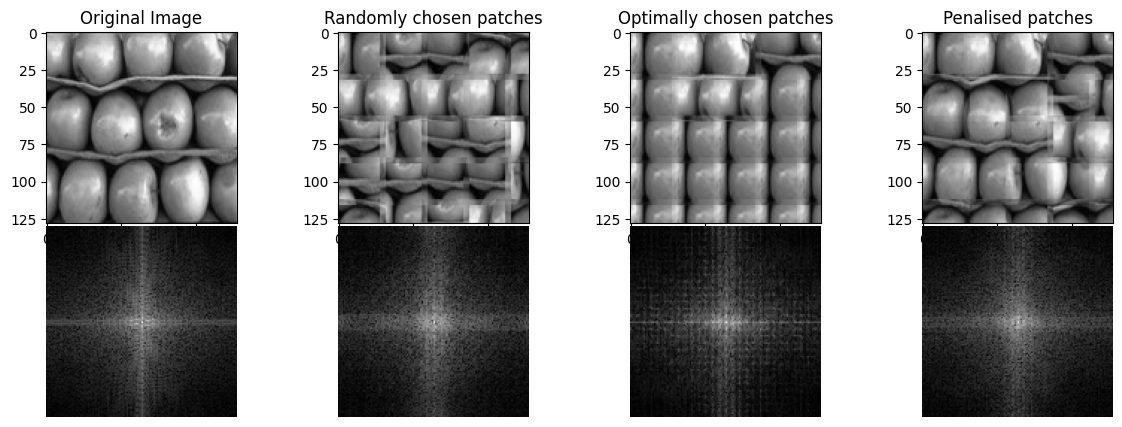

In [14]:
fig, axes = plt.subplots(
    2, 4, figsize=(15, 5), gridspec_kw={"wspace": 0.02, "hspace": 0.02}
)
for ax, image, title in zip(
    axes[0],
    naive_images,
    [
        "Original Image",
        "Randomly chosen patches",
        "Optimally chosen patches",
        "Penalised patches",
    ],
    strict=True,
):
    ax.imshow(image, cmap="gray")
    ax.set_title(title)

for ax, fft in zip(axes[1], ffts, strict=True):
    ax.imshow(np.log(fft + 1), cmap="gray")
    ax.axis("off")

In [15]:
from skimage.filters import sobel

edges = [sobel(i) for i in naive_images]

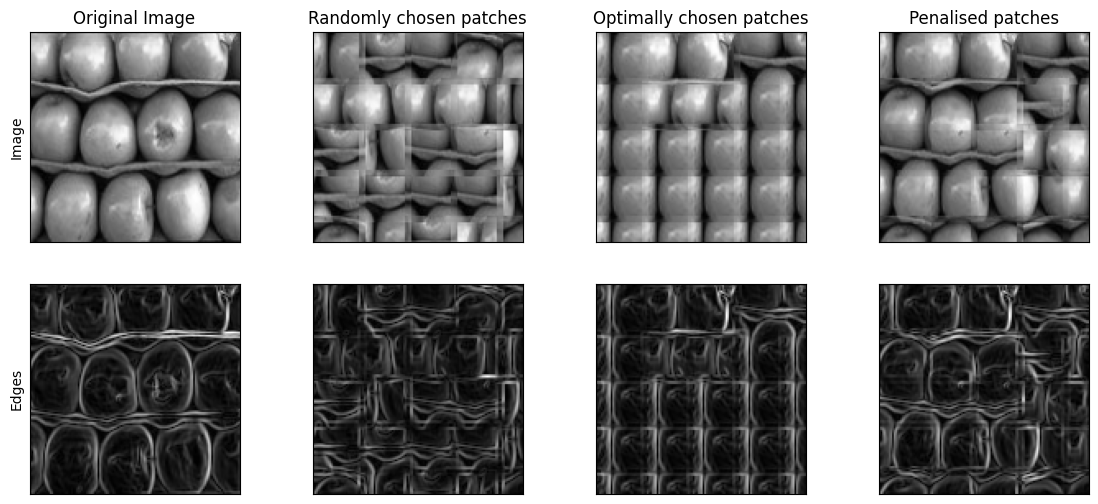

In [16]:
fig, axes = plt.subplots(2, 4, figsize=(14, 6))

for axes_, imgs in zip(axes, [naive_images, edges]):
    for axis, img in zip(axes_, imgs, strict=True):
        axis.imshow(img, cmap="gray")
        axis.set_xticks([])
        axis.set_yticks([])

for axis, title in zip(
    axes[0],
    [
        "Original Image",
        "Randomly chosen patches",
        "Optimally chosen patches",
        "Penalised patches",
    ],
    strict=True,
):
    axis.set_title(title)

for axis, title in zip(
    axes[:, 0],
    [
        "Image",
        "Edges",
    ],
    strict=True,
):
    axis.set_ylabel(title)

In [17]:
# We can do better though, by stitching the patches together
# This is the quilting algorithm, which stitches patches together by finding optimal cuts through the patches
# and aligning them with the patches next to them
quilted = quilting.quilt(
    patches,
    target_size=target_size,
    patch_overlap=patch_overlap,
    rng=rng,
    repeat_penalty=1,
)

stitched_images = [*naive_images[1:], quilted]
stitched_edges = [*edges[1:], sobel(quilted)]

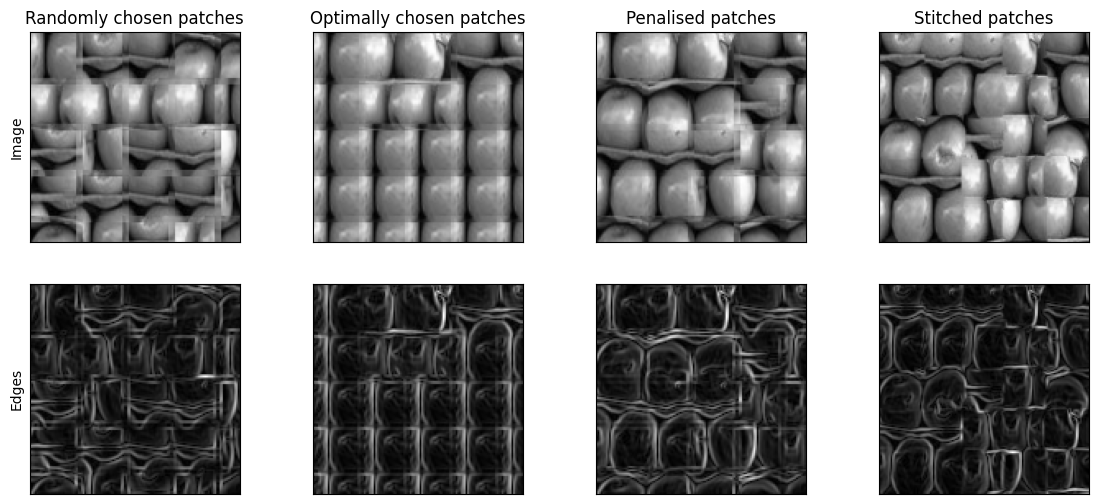

In [18]:
fig, axes = plt.subplots(2, 4, figsize=(14, 6))

for axes_, imgs in zip(axes, [stitched_images, stitched_edges]):
    for axis, img in zip(axes_, imgs, strict=True):
        axis.imshow(img, cmap="gray")
        axis.set_xticks([])
        axis.set_yticks([])

for axis, title in zip(
    axes[0],
    [
        "Randomly chosen patches",
        "Optimally chosen patches",
        "Penalised patches",
        "Stitched patches",
    ],
    strict=True,
):
    axis.set_title(title)

for axis, title in zip(
    axes[:, 0],
    [
        "Image",
        "Edges",
    ],
    strict=True,
):
    axis.set_ylabel(title)

In [19]:
# Let's also visualise the stitches
def add_patch_with_seam(
    existing_image: np.ndarray,
    candidate_patch: np.ndarray,
    position: tuple[int, int],
    seam_img: np.ndarray,
) -> np.ndarray:
    """
    Add a candidate patch to an existing image at a given position, stitching them using the optimal seam.

    Also return the seam
    """
    existing_patch = quilting._image_region(
        existing_image, candidate_patch.shape, position
    )

    cost = quilting.overlap_cost(existing_image, candidate_patch, position)
    seam_edges: tuple[str, str] = quilting._identify_seam_edges(cost)

    # Find the minimal cost seam through the cost matrix
    seam = quilting.seam_nodes(cost, *seam_edges)

    # Use this seam to stitch the patch onto the existing image
    merged_patch = quilting._merge_patches(
        existing_patch, candidate_patch, seam, seam_edges
    )

    # Place the merged patch back into the existing image
    result = existing_image.copy()
    result[
        position[0] : position[0] + merged_patch.shape[0],
        position[1] : position[1] + merged_patch.shape[1],
    ] = merged_patch

    # Add the seam to the image
    seam_patch = np.zeros_like(merged_patch)

    seam = np.array(seam)
    y_seam, x_seam = seam[:, 0], seam[:, 1]
    seam_patch[y_seam, x_seam] = 1

    seam_img = seam_img.copy()
    seam_img[
        position[0] : position[0] + merged_patch.shape[0],
        position[1] : position[1] + merged_patch.shape[1],
    ] = seam_patch

    return result, seam_img


patch_sizes = {patch.shape for patch in patches}

# Find how many patches we need to build up to the target size
n_col, n_row = quilting._patch_layout(target_size, patch_size, patch_overlap)
patch_grid = quilting.optimally_choose_patches(
    patches,
    target_size,
    patch_overlap,
    rng=rng,
    repeat_penalty=1.0,
)

# Init an array of the right size ()
array_size = (
    n_row * (patch_size[0] - patch_overlap) + patch_overlap,
    n_col * (patch_size[1] - patch_overlap) + patch_overlap,
)
result = quilting._unfilled_image(array_size)
seam_img = np.zeros_like(result)

result[0 : patch_size[0], 0 : patch_size[1]] = patch_grid[0][0]

# Now stitch the patches together
for i in range(n_row):
    for j in range(n_col):
        if i == 0 and j == 0:
            continue
        # Get the position of the patch in the result array
        pos_y = i * (patch_size[0] - patch_overlap)
        pos_x = j * (patch_size[1] - patch_overlap)

        result, seam_img = add_patch_with_seam(result, patch_grid[i][j], (pos_y, pos_x), seam_img)


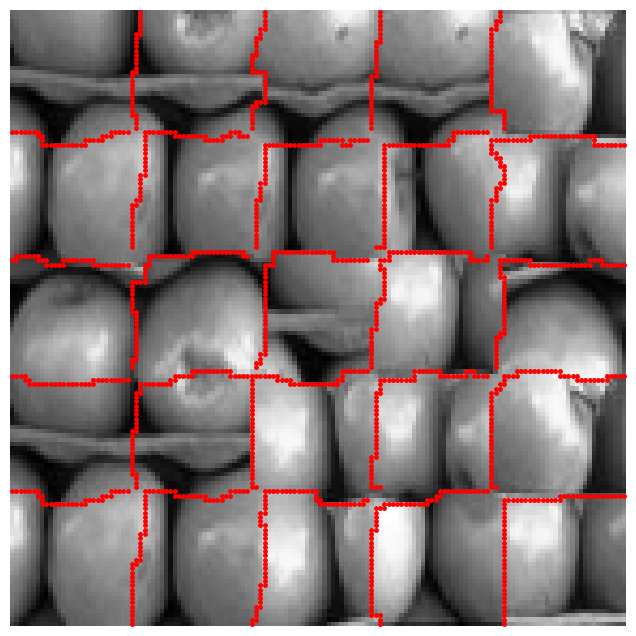

In [20]:
fig, axes = plt.subplots(figsize=(8, 8))

axes.imshow(result, cmap="gray")
axes.axis("off")

ys, xs = np.where(seam_img > 0)
plt.plot(xs, ys, "r.", markersize=5)

(np.float64(-0.5), np.float64(143.5), np.float64(143.5), np.float64(-0.5))

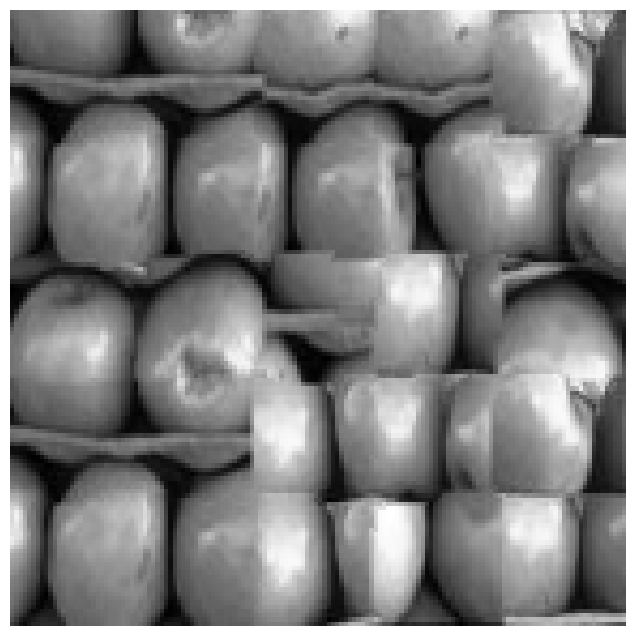

In [21]:
fig, axes = plt.subplots(figsize=(8, 8))

axes.imshow(result, cmap="gray")
axes.axis("off")
